# NeMo Inference Experiments

In [1]:
import sys
sys.path.append('../code/lib')

from MeshUtils import *
from PIL import Image
import io  
import os
import matplotlib.pyplot as plt

In [10]:
''' Parameters and Settings '''

cate = 'car'
mesh_d = 'multi'
occ_level = ''
device = 'cuda:0'
down_sample_rate = 8

# path to 
mesh_path = '../data/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off'
img_path = '../data/PASCAL3D_NeMo/images/' + cate + '/%s.JPEG'

# names of images
names = os.listdir('../data/PASCAL3D_NeMo/images/' + cate)

# path to annotations
annos_path = '../data/PASCAL3D_NeMo/annotations/' + cate + '/%s.npz'

# path to saved features file
record_file_path = '../exp/Features_' + mesh_d + '/' + cate +  '/saved_feature_%s_%s.npz' % (cate, mesh_d)

# path to save images
save_dir = '../exp/aligns_final/' + cate + '_' + mesh_d + '/'

# remove .jpg suffix from image names
image_names = [t.split('.')[0] for t in names]

# image size of renderings for the car category
image_size = (256, 672)

# distance of camera from model for rendering
distance_render = {'car': 5}

In [11]:
''' plotting function for loss landscape '''
def plot_fun(values, para_scans, colors, figsize=(10.5, 4)):
    plt.figure(num=None, figsize=figsize)
    ax = plt.axes()

    for v, p, c in zip(values, para_scans, colors):
        ax.plot(v, p, c)
    plt.axvline(x=0, c='black')
    return ax

''' Converts a matplotlib plot into a numpy array type image '''
def get_one_image_from_plt(plot_functions, plot_args=tuple(), plot_kwargs=dict()):
    plt.cla()
    plt.clf()
    ax = plot_functions(*plot_args, **plot_kwargs)
    positions = ax.get_position()
    pos = [positions.y0, positions.y1, positions.x0, positions.x1]
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    im = Image.open(buf)
    img = np.array(im)
    h, w = img.shape[0:2]
    box = bbt.from_numpy([np.array([int(t[0] * h), int(t[1] * h), int(t[2] * w), int(t[3] * w)]) for t in [pos]][0])
    box = box.pad(1)
    box = box.shift((2, 1))
    img = box.apply(img)
    bbt.draw_bbox(img, bbt.full(img.shape).pad(-2), boundary=(0, 0, 0), boundary_width=11)
    # img = np.transpose(img, (1, 0, 2))
    return img

In [21]:
# SELECT IMAGE
img_idx = 1
image_name = image_names[img_idx]

annos_file = np.load(annos_path % image_name, allow_pickle=True)
# print(image_name)

# load vertices and faces based on type of model
if mesh_d == 'single':
    xvert, xface = load_off('../data/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off' % 1, to_torch=True)
    subtype = 'mesh%02d' % 1
else:
    xvert, xface = load_off('../data/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off' % annos_file['cad_index'], to_torch=True)
    subtype = 'mesh%02d' % annos_file['cad_index']

# load record file TODO: WHAT IS THAT
record_file = np.load(record_file_path)

# create feature bank
feature_bank = torch.from_numpy(record_file['memory_%s' % subtype])

# get predicted map
predicted_map = record_file[image_name]
predicted_map = torch.from_numpy(predicted_map).to(device)

#     cameras = OpenGLPerspectiveCameras(device=device, fov=12.0)
#     raster_settings = RasterizationSettings(
#         image_size=render_image_size,
#         blur_radius=0.0,
#         faces_per_pixel=1,
#         bin_size=0
#     )
#     rasterizer = MeshRasterizer(
#         cameras=cameras,
#         raster_settings=raster_settings
#     )

# rasterizer = 

# create interpolation module
# inter_module = MeshInterpolateModule(xvert, xface, feature_bank, rasterizer, post_process=center_crop_fun(predicted_map.shape[1::], (render_image_size, ) * 2))
# inter_module.cuda()

azimuth_shifts = np.linspace(-3.14, 3.14, 121)
elevation_shifts = np.linspace(-3.14 / 2, 3.14 / 2, 61)
theta_shifts = np.linspace(-3.14 / 2, 3.14 / 2, 61)
distance_shifts = np.linspace(-2, 2, 41)

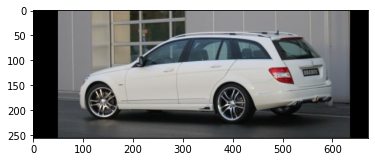

In [22]:
import cv2
img = cv2.imread(img_path%image_name, -1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [23]:
for item in annos_file:
    print(f'{item} = {annos_file[item]}')

'''
Annotation example:
    name = n02814533_10404
    box = [151. 407. 157. 829. 427. 829.]
    box_ori = [140. 275. 295. 469. 335. 500.]
    box_obj = [ 27. 200. 219. 441. 256. 672.]
    cropped_kp_list = [[  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [ 48.23357636 254.21345823]
    [ 48.23357636 378.73558693]
    [  0.           0.        ]
    [  0.           0.        ]
    [ 88.79700593 232.89885963]
    [ 93.30405366 386.58833379]]
    visible = [2 2 2 2 2 2 1 1 2 2 1 1]
    occ_mask = None
    theta = -0.02453757441330697
    focal = 1
    elevation = -0.02975584770042751
    viewport = 3000
    width = 500
    azimuth = 3.243096872126876
    principal = [386.21454547 218.99966294]
    show more (open the raw output data in a text editor) ...

    principal = [386.21454547 218.99966294]
    distance = 6.384374659693176
    height = 335
    cad_index = 6
    bbox = [295.87205082 140.77676951 469.19328494 275.07803993]
''';

name = n02814533_10268
box = [159. 415.   0. 672. 439. 672.]
box_ori = [180. 343.  39. 491. 392. 524.]
box_obj = [ 42. 225.  93. 600. 256. 672.]
cropped_kp_list = [[  0.           0.        ]
 [  0.           0.        ]
 [182.96654751 140.58019476]
 [186.43188735 403.70722424]
 [  0.           0.        ]
 [ 61.67965316 275.60590725]
 [ 61.67965316 481.02964079]
 [  0.           0.        ]
 [  0.           0.        ]
 [137.91712961 107.11228312]
 [100.95350466 501.80282733]
 [ 95.17793826 581.43337572]]
visible = [2 2 1 1 2 1 1 2 2 1 1 1]
occ_mask = None
theta = 0.014330018244559657
focal = 1
elevation = 0.025908425927691478
viewport = 3000
width = 524
azimuth = 2.1662221779600106
principal = [255.9264349  257.05179795]
distance = 5.601066265043189
height = 392
cad_index = 6
bbox = [ 39.96642468 180.33303085 491.69056261 343.90471869]


In [26]:
np.array(pt, dtype=int)[::-1]

array([0, 0])

(256, 672, 3)


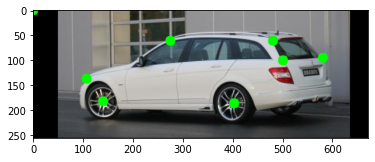

In [28]:
img = cv2.imread(img_path%image_name, -1)

for pt in annos_file['cropped_kp_list']:
    cv2.circle(img=img, center=np.array(pt, dtype=int)[::-1], radius=10, color=(0,255,0), thickness=-1)

# cv2.circle(img=img, center=np.array(annos_file['principal'], dtype=int), radius=10, color=(0,0,255), thickness=-1)    
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()

In [29]:
box = bbt.from_numpy(annos_file['box'])
box_ori = bbt.from_numpy(annos_file['box_ori'])
box_obj = bbt.from_numpy(annos_file['box_obj'])
print(box,'\n', box_ori,'\n', box_obj)

<class "Bbox2D", bbox=[(159, 415), (0, 672)], boundary=[439, 672]> 
 <class "Bbox2D", bbox=[(180, 343), (39, 491)], boundary=[392, 524]> 
 <class "Bbox2D", bbox=[(42, 225), (93, 600)], boundary=[256, 672]>


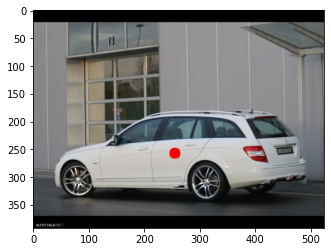

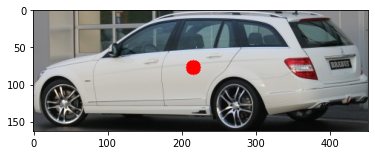

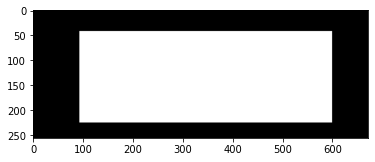

In [55]:
img = cv2.imread('/media/gkouros/Elements SE/Datasets/pascal3d/PASCAL3D+_release1.1/Images/car_imagenet/n02814533_10268.JPEG', -1)
cv2.circle(img=img, center=np.array(annos_file['principal'], dtype=int), radius=10, color=(0,0,255), thickness=-1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()
# img2 = box.apply(img)
# plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.show()
img3 = box_ori.apply(img)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)); plt.show()
# img4 = box_obj.apply(img)
# plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)); plt.show()
obj_mask = np.zeros(box_obj.boundary, dtype=np.float32)
box_obj.assign(obj_mask, 1)
plt.imshow(cv2.cvtColor(obj_mask, cv2.COLOR_BGR2RGB)); plt.show()

In [34]:
# # """ read original pascal3D annotation file """

# import numpy as np
# from scipy.io import loadmat
# from pprint import pprint
# import json
# # mat = np.loadtxt('/media/gkouros/Elements SE/Datasets/pascal3d/PASCAL3D+_release1.1/Annotations/car_imagenet/n04285965_9991.mat')
# mat = loadmat('/media/gkouros/Elements SE/Datasets/pascal3d/PASCAL3D+_release1.1/Annotations/car_imagenet/n04285965_9991.mat')
# print(mat)

In [31]:
# """ read original pascal3D annotation file """
import numpy as np
from scipy.io import loadmat
from pprint import pprint
import json
data1 = np.load('/media/gkouros/Elements SE/Datasets/pascal3d/PASCAL3D_NeMo/annotations3D_single/aeroplane/n04012084_9993.npz', allow_pickle=True)
data2 = np.load('/media/gkouros/Elements SE/Datasets/pascal3d/PASCAL3D_NeMo/annotations/aeroplane/n04012084_9993.npz', allow_pickle=True)
print(mat)

NameError: name 'mat' is not defined

In [32]:
for item in data1.files:
    # print(item, ': ', data1[item])
    # if data1[item] != data2[item]:
    print(data1[item], data2[item])

n04012084_9993 n04012084_9993
[ 677.  997.  497. 1521. 1497. 1996.] [ 677.  997.  497. 1521. 1497. 1996.]
[174. 231. 188. 294. 375. 500.] [174. 231. 188. 294. 375. 500.]
[  17.  245.  253.  676.  320. 1024.] [  17.  245.  253.  676.  320. 1024.]
[[281.         276.94339623]
 [277.         296.89622642]
 [277.         316.8490566 ]
 ...
 [ 53.         771.77358491]
 [ 53.         783.74528302]
 [ 49.         791.72641509]] [[120.19101124 287.18883824]
 [ 79.74157303 663.82653169]
 [ 69.62921348 576.39278143]
 [167.38202247 435.15364639]
 [  0.           0.        ]
 [106.70786517 562.94143523]
 [110.07865169 653.73802205]
 [116.82022472 599.93263727]]
[False False False ... False False False] [1 1 1 1 2 1 1 1]
None None
0.152555603187018 0.152555603187018
1 1
0.07454728513751638 0.07454728513751638
3000 3000
500 500
0.4932998908260338 0.4932998908260338
[252.9732068  209.82716239] [252.9732068  209.82716239]
19.96025425065619 19.96025425065619
375 375
1 3
[188.79401089 174.38838475 294.

KeyError: 'kp_weights is not a file in the archive'

In [57]:
import sys
sys.path.append('../code')
from dataset.Pascal3DPlus import Pascal3DPlus

In [70]:
dataset = Pascal3DPlus(None, rootpath='../data/PASCAL3D_train_NeMo', imgclass='car')
dataset[0]

{'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=672x256 at 0x7F8CEE95D5B0>,
 'kp': array([[  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [197.82428963, 394.47121437],
        [197.82428963, 484.7918849 ],
        [ 49.10809654, 247.49485052],
        [ 50.75136939, 397.75560239],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [128.80682985, 153.88979198],
        [137.02319411, 335.35223003],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ]]),
 'iskpvisible': array([False, False,  True,  True,  True,  True, False, False,  True,
         True, False, False]),
 'this_name': 'n02814533_11078',
 'obj_mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'box_obj': (210, 3

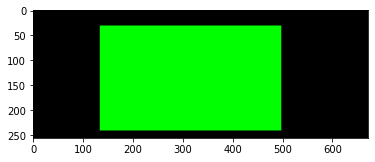

In [100]:
img1 = cv2.cvtColor(dataset[0]['obj_mask'], cv2.COLOR_GRAY2BGR)
img1 = cv2.normalize(img1, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img1[..., 0] = 0
img1[..., 2] = 0
plt.imshow(img1)


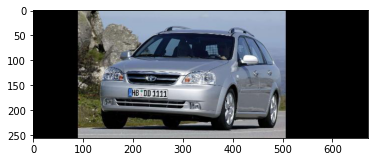

In [90]:
img2 = np.asarray(dataset[0]['img'])
plt.imshow(img2)

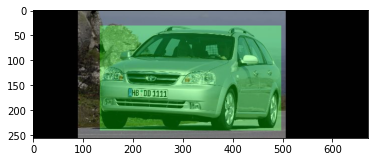

In [101]:
a = cv2.addWeighted(
    src1=img1,
    alpha=0.3,
    src2=img2,
    beta=0.7,
    gamma=1
)
plt.imshow(a)